# Assignment 2021

In [1]:
# Importing packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d  #for 3D plot 
from scipy.integrate import odeint
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy import linalg as la
from scipy.stats import poisson  

# Exercise 1: Calibration

In [2]:
# Let's import the dataset

file = pd.read_csv('data_provinces.csv')
file = file.drop(['Unnamed: 0'],axis=1)
file.columns = ['Lodi','Pavia','Sondrio','Mantova','Milano','Como','Brescia','Monza/Brianza','Lecco','Cremona','Bergamo','Varese']
for i in file.columns:
    file[f'{i}_cum_sum'] = np.cumsum(file[i]) 

In [3]:
test_set = [64, 68, 74, 74, 68, 68, 68, 68, 70, 66, 66, 73] #Given time-range for each city
range_of_time = [np.arange(1, ndays+1, 1) for ndays in test_set] 
ST_SUSCE = [44927, 71881, 21476, 48834, 1406242, 85542, 196339, 124839, 48057, 72398, 120782, 80723] #Susceptible population for each city

In [4]:
# Defining the S-E-I-R equation

def SEIR_eq(y0,t, alfa, beta, gamma, mu):
    S, E, I, R = y0  
    N = S + E + I + R
    dS_dt = (-1)*((beta)*(I/N))*S + mu * (N) - mu * (S)
    dE_dt = ((beta)*(I/N))*S - (alfa * E) - mu * (E)
    dI_dt = (alfa * E) - (gamma * I) - mu * (I)
    dR_dt = gamma * I - mu * (R)
    return dS_dt, dE_dt, dI_dt, dR_dt

In [5]:
# Function to calibrate the beta coefficient, making R0 round from 1 to 3

def R0_trials(ST_SUSCE, time_range, column_data, a, title):
    MSEs = []  
    I_hats = []
    d = 5
    R0s = np.arange(1, 3, 0.001)
    for R0 in R0s:
        alfa = 0.2  #Determined via assumption
        mu = 0.001  # Determined via assumption
        beta= (R0*(1/d))
        gamma= 1/d  # Determined via assumption
        SEIR = odeint(SEIR_eq, (ST_SUSCE-1, 1, 0, 0), time_range, args=(alfa, beta, gamma, mu))
        S, E, I_hat, R = SEIR.T
        I_daily = (I_hat[1:]+R[1:])-(I_hat[:-1]+R[:-1])
        I_hats.append(I_daily)
        true_data = column_data[:len(I_daily)]
        MSE = np.sqrt(sum((I_daily-true_data)**2)/len(true_data))  # Calculation of Mean Squared Error
        MSEs.append(MSE)
    cal = pd.DataFrame({'R0': R0s, 'MSE': MSEs, 'I_hat': I_hats})
    best_model = cal.loc[cal['MSE'].idxmin()]
    print('BEST MODEL {}: RO: {}, MSE:{}'.format(title, round(best_model['R0'], 2), round(best_model['MSE'],2)))
    
    # Plots
    
    fig, axs = plt.subplots(1,3, facecolor='w', figsize=(10,3))
    fig.suptitle(f'{title}')
    
    # Plot for comparison between true data and simulated data
    
    axs[0].set_title('Best Model: \n RO: {}, MSE:{}'.format(round(best_model['R0'], 2), round(best_model['MSE'],2)))
    axs[0].scatter(time_range, column_data[:len(time_range)], color = 'b', label = 'I_data')
    axs[0].plot(time_range[:-1] ,best_model['I_hat'], alpha=1, lw=2, label='I_daily', color = 'darkred')
    
    # Plot for comparison between models tested and best model
    
    axs[1].set_title('Models Tested')
    axs[1].plot(time_range[:-1], I_hats[0], alpha=0.5,  color = 'k', lw=1, label ='models tested' )
    for R0, I in zip(R0s, I_hats[1:]):
        if R0 == best_model['R0']:
            axs[1].plot(time_range[:-1], I, c = 'darkred', lw=5, label = 'best model')
        else:
            axs[1].plot(time_range[:-1], I, alpha=0.05,  color = 'k', lw=1)
            
    # Plot to see the trend of Mean Squared Error
        
    axs[2].set_title('MSEs')
    axs[2].scatter(cal['R0'], cal['MSE'], color = 'k' , s =1 )
    axs[2].scatter(best_model['R0'], best_model['MSE'], color = 'darkred' , s =50, label='min MSE' )
    axs[2].axvline(x= best_model['R0'], ymin=0, ymax=2, c= 'b')
    axs[2].set_xlabel('R0s')
    axs[2].set_ylabel('MSEs')
    
    for i in range(3):
        axs[i].legend(fancybox = True)
        for spine in ('top', 'right'): 
            axs[i].spines[spine].set_visible(False)
            
    fig.tight_layout()

BEST MODEL Lodi: RO: 2.39, MSE:9.61
BEST MODEL Pavia: RO: 2.19, MSE:5.94
BEST MODEL Sondrio: RO: 1.82, MSE:2.45
BEST MODEL Mantova: RO: 2.07, MSE:4.59
BEST MODEL Milano: RO: 2.53, MSE:14.96
BEST MODEL Como: RO: 1.97, MSE:3.26
BEST MODEL Brescia: RO: 2.59, MSE:19.31
BEST MODEL Monza/Brianza: RO: 2.14, MSE:5.14
BEST MODEL Lecco: RO: 2.1, MSE:5.29
BEST MODEL Cremona: RO: 2.42, MSE:7.34
BEST MODEL Bergamo: RO: 2.64, MSE:22.83
BEST MODEL Varese: RO: 2.01, MSE:3.51


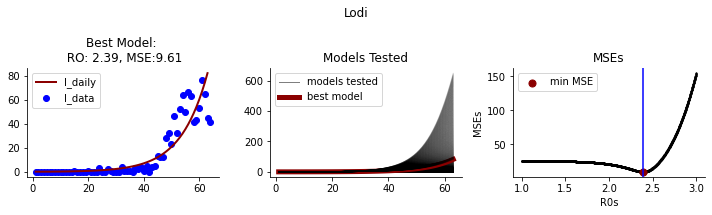

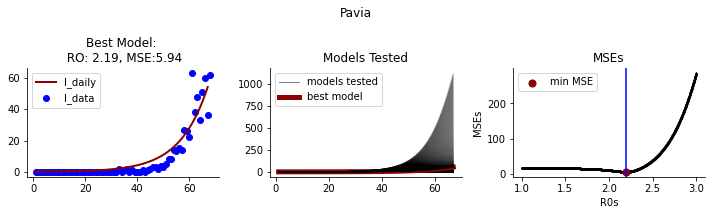

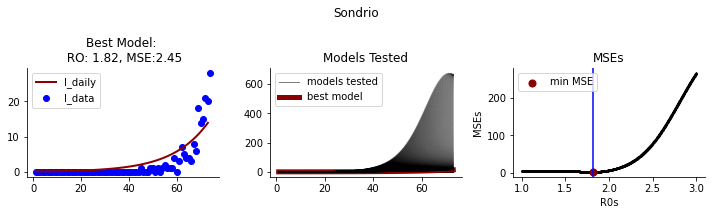

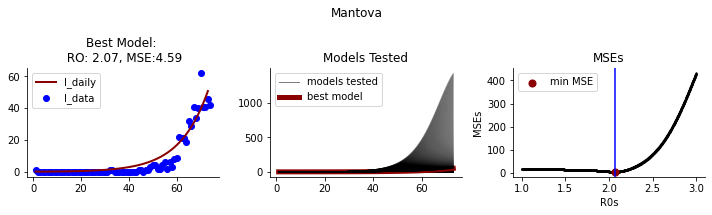

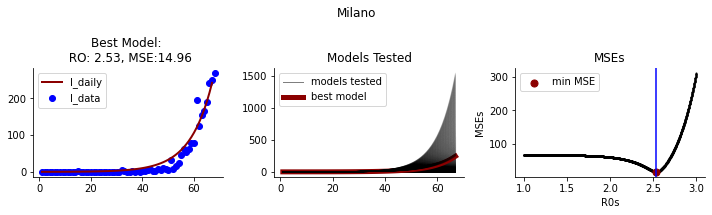

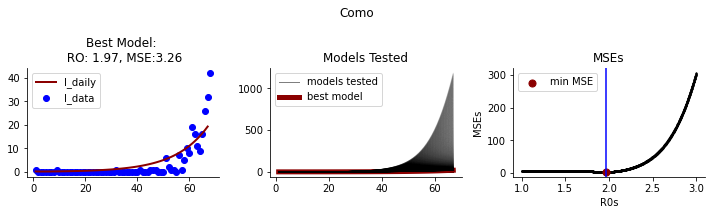

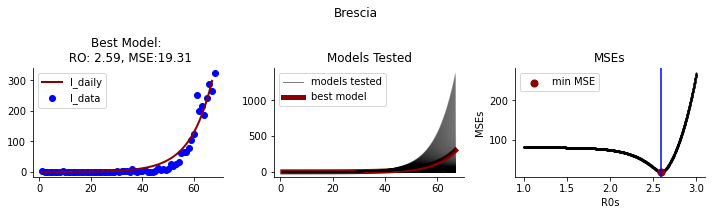

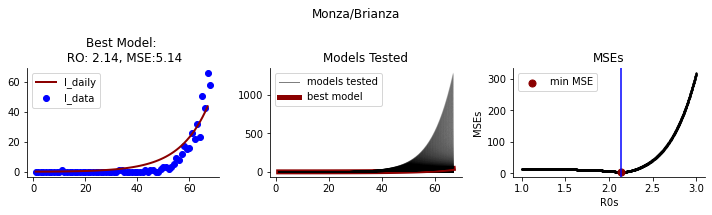

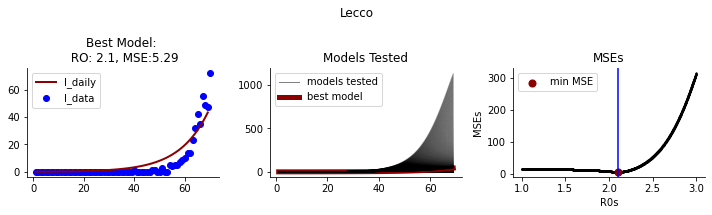

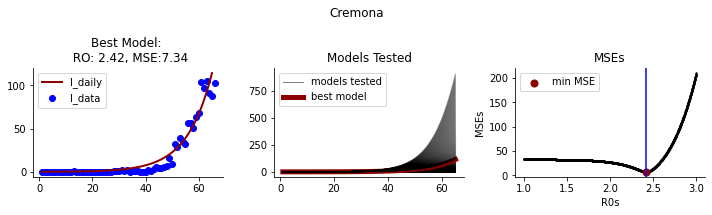

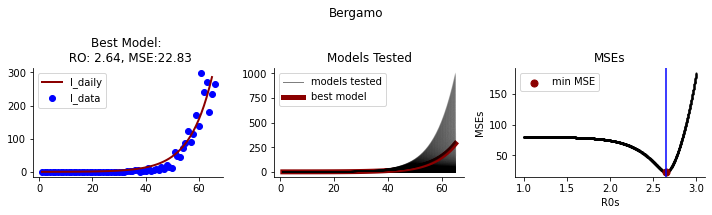

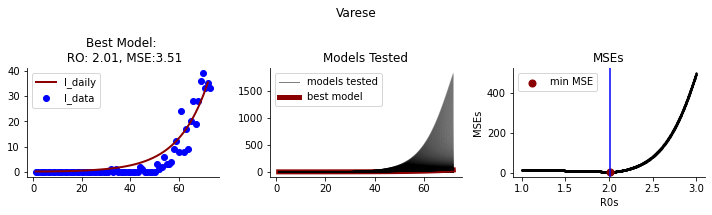

In [6]:
# Let's loop over the different values for each city that we defined before

for i in range(12):
    R0_trials(ST_SUSCE[i], range_of_time[i], file[list(file.columns)[i]], 92-test_set[i], list(file.columns)[i])

In [7]:
# Let's compare the result obtained with MSE for COMO with a METROPOLIS-HASTINGS function

# Function to compute likelihood

def compute_likelihood(data, data_hat):
    lkh = 1
    for i in range(len(data)-1):
        lkh = lkh * poisson.pmf(data[i],data_hat[i]) #poisson likelihood to observe the data with a model
        if str(lkh) == 'nan':
            lkh = 0
            break
    return lkh

# Function to compute log-likelihood

def compute_loglikelihood(data, data_hat):
    llkh = 0
    for i in range(len(data)-1):
        llkh = llkh + np.log(poisson.pmf(data[i],data_hat[i])) #poisson likelihood to observe the data with a model
    return llkh

std = 0.01  # Standard error
iterations = 4000  # Number of iterations that we want to compute in the metropolis hastings

def metropolis_hastings(iterations, beta_start, std, true_data, ST_SUSCE, time_range):
    alfa = 0.2  # Assumtpion
    mu = 0.001  # Assumption
    gamma = 1/5  # Assumption
    SEIR = odeint(SEIR_eq, (ST_SUSCE-1, 1, 0, 0), time_range, args=(alfa, beta_start, gamma, mu))
    I_hat, R = SEIR.T[2:]
    I_daily = (I_hat[1:]+R[1:])-(I_hat[:-1]+R[:-1])
    llkh_start = compute_loglikelihood(true_data, I_daily)
    
    
    BETAS =[beta_start]
    llkh = [llkh_start]
    
    for ITER in range(iterations):
    
        beta_current = BETAS[-1]
        llkh_current = llkh[-1]

        beta_new = np.random.normal(beta_current, std, size = 1)
        SEIR = odeint(SEIR_eq, (ST_SUSCE-1, 1, 0, 0), time_range, args=(alfa, beta_new, gamma, mu))
        I_hat, R = SEIR.T[2:]

        I_daily = (I_hat[1:]+R[1:])-(I_hat[:-1]+R[:-1])
        llkh_new = compute_loglikelihood(true_data, I_daily)

        alpha  = np.e**(llkh_new - llkh_current)

        if alpha <= np.random.uniform(0,1): 
            BETAS.append(beta_current)
            llkh.append(llkh_current)

        else: 
            BETAS.append(beta_new)
            llkh.append(llkh_new)
      
    # We discard the first 400 iterations. 

    BETAS = BETAS[400:] 
    llkh = llkh[400:]
    
    return np.array(BETAS).flatten(), np.array(llkh).flatten()

In [8]:
# We make the function start from 3 different values, to see if the convergence between the 3 is the same even with different starting values

BETAS_1, llkh_1 = metropolis_hastings(iterations, 0.3, std, file[list(file.columns)[5]][:68], ST_SUSCE[5], range_of_time[5])  
BETAS_2, llkh_2 = metropolis_hastings(iterations, 0.2, std, file[list(file.columns)[5]][:68], ST_SUSCE[5], range_of_time[5]) 
BETAS_3, llkh_3= metropolis_hastings(iterations, 0.4, std, file[list(file.columns)[5]][:68], ST_SUSCE[5], range_of_time[5]) 

In [9]:
B = [BETAS_1, BETAS_2, BETAS_3]
LLK = [llkh_1, llkh_2, llkh_3]

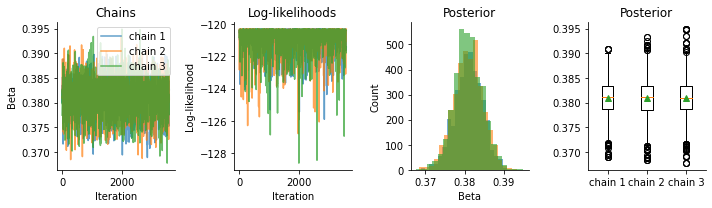

In [10]:
# Plots

fig, axs = plt.subplots(1,4, facecolor='w', figsize=(10,3))

axs[0].set_title('Chains')
axs[1].set_title('Log-likelihoods')
axs[2].set_title('Posterior')
axs[3].set_title('Posterior')

for i in range(3):
    BETAS = B[i]
    llk = LLK[i]
    
    axs[0].plot(range(len(BETAS)), BETAS, label = 'chain {}'.format(i+1), alpha = 0.7)
    axs[1].plot(range(len(llk)), llk, alpha = 0.7)
    axs[2].hist(BETAS, bins = 20, alpha = 0.6)

axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Beta')

axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Log-likelihood')

axs[2].set_xlabel('Beta')
axs[2].set_ylabel('Count')

axs[3].boxplot(B, showmeans=True)
plt.setp(axs[3], xticklabels=['chain 1', 'chain 2', 'chain 3']);

axs[0].legend(fancybox = True)

for i in range(4):
    for spine in ('top', 'right'): 
        axs[i].spines[spine].set_visible(False)
        
fig.tight_layout()
fig.savefig(f"Metro-Como.png")

In [11]:
# Means for every different metropolis_hastings function we computed

np.mean(BETAS_1), np.mean(BETAS_2),  np.mean(BETAS_3)

(0.38100329805579064, 0.3809372921523364, 0.3809353386355413)

# Exercise 2: Adding age structure to the model

In [12]:
# Let's import both the contact matrix and the age-ranges we computed from istat

matrix = pd.read_csv('italian_matrix.csv').drop(['Unnamed: 0'], axis=1) 
como_pop = pd.read_excel('Popolazione_como.xlsx')

In [13]:
# We firstly compute the proportions over the different age-ranges that we have found on ISTAT

proporzione = np.array([i/597642 for i in como_pop['Population']])

# When we have the proportion of inhabitants for every age-range, we multiply those proportion with the given population of 
# Como, so 85543

S0 = (85543) * proporzione

# Thanks to this, we have the real proportion, but applied to the number given in the PDF

COMO = [i for i in S0] # List of starting S, this will be the Nj we will put in the S-I-R equation

S0[-1] = S0[-1] - 1 # We remove the first infected

I0 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]) * proporzione # We start the infection from the oldest age-range

R0 = np.array([0]*16) 

INPUT =np.hstack((S0,I0,R0)) 

In [14]:
# SIR EQUATION

def SIR_eq(INPUT,t, BETA, gamma, listone):
    Y=np.zeros((48))
    S, I, R = INPUT[:16], INPUT[16:32], INPUT[32:] 
    k= 16
    for i in range(k):
        SUM = np.dot(BETA[i], I/listone) * S[i]
        Y[i] = (-1) * SUM
        Y[(k+i)] = SUM - (gamma) * I[i]
        Y[(2*k+i)] = (gamma) * I[i]
    return Y

In [15]:
def R0_trials1(INPUT, time, matrix, listone):
    MSEs = []  
    I_hats = []
    lista_Q = [] # list where to store each q that we test, thanks to the rotation of R0
    d = 5 
    R0s = np.arange(1, 3, 0.001)
    for R0 in R0s:
        gamma= 1/d
        q = R0 * gamma / round(np.max(la.eigvals(matrix)).real, 5)
        valore_matrice = q * matrix.values
        RES = odeint(SIR_eq, INPUT ,t, args=(valore_matrice, gamma, listone))
        S, I, R = RES.T[:16], RES.T[16:32], RES.T[32:]
        for i in range(len(I)):
            I_daily = (I[i][1:] + R[i][1:]) - (I[i][:-1] + R[i][:-1]) # Computing I_daily
        I_hats.append(I_daily)
        lista_Q.append(q)
        true_data = file['Como'][:len(I_daily)]
        MSE = np.sqrt(sum((I_daily-true_data)**2)/len(true_data))
        MSEs.append(MSE)
    cal = pd.DataFrame({'R0': R0s, 'MSE': MSEs, 'I_hat': I_hats, 'q': lista_Q, 'I_hats' : I_hats})
    best_model = cal.loc[cal['MSE'].idxmin()]
    print('BEST MODEL {}: RO: {}, MSE:{}, q:{}'.format('Best', round(best_model['R0'], 2), round(best_model['MSE'],2), best_model['q']))
    
    # Plots
    
    fig, axs = plt.subplots(1,3, facecolor='w', figsize=(10,3))
    fig.suptitle('Como')
    
    # Plot for comparison between true data and simulated data
    
    axs[0].set_title('Best Model: \n RO: {}, MSE:{}'.format(round(best_model['R0'], 2), round(best_model['MSE'],2)))
    axs[0].scatter(time,file['Como'][:len(time)], color = 'b', label = 'I_data')
    axs[0].plot(time[:-1] ,best_model['I_hat'], alpha=1, lw=2, label='I_daily', color = 'darkred')
    
    # Plot for comparison between models tested and best model
    
    axs[1].set_title('Models Tested')
    axs[1].plot(time[:-1], I_hats[0], alpha=0.5,  color = 'k', lw=1, label ='models tested' )
    for R0, I in zip(R0s, I_hats[1:]):
        if R0 == best_model['R0']:
            axs[1].plot(time[:-1], I, c = 'darkred', lw=5, label = 'best model')
        else:
            axs[1].plot(time[:-1], I, alpha=0.05,  color = 'k', lw=1)
        
    # Plot to see the trend of Mean Squared Error
    
    axs[2].set_title('MSEs')
    axs[2].scatter(cal['R0'], cal['MSE'], color = 'k' , s =1 )
    axs[2].scatter(best_model['R0'], best_model['MSE'], color = 'darkred' , s =50, label='min MSE' )
    axs[2].axvline(x= best_model['R0'], ymin=0, ymax=2, c= 'b')
    axs[2].set_xlabel('R0s')
    axs[2].set_ylabel('MSEs')
    
    for i in range(3):
        axs[i].legend(fancybox = True)
        for spine in ('top', 'right'): 
            axs[i].spines[spine].set_visible(False)
            
    fig.tight_layout()
    fig.savefig(f"Como22.png")

BEST MODEL Best: RO: 1.9, MSE:2.35, q:0.018157766776550364


<ipython-input-15-5b95a1b4b23a>:59: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
<ipython-input-15-5b95a1b4b23a>:60: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(f"Como22.png")
C:\Users\alber\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


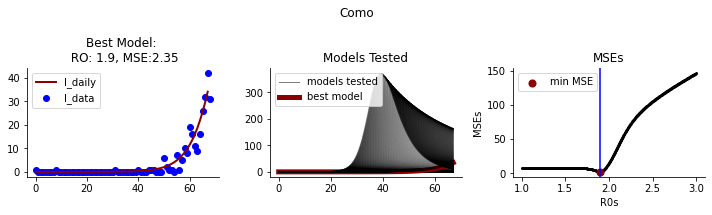

In [16]:
T =  68
steps_per_t = 1
t = np.arange(0, T+1, 1/steps_per_t)

R0_trials1(INPUT, t, matrix, COMO)

In [17]:
q = 0.018157766776550364 # BEST Q, found thanks to minimizing Mean Squared Error

In [18]:
valore_matrice = q*(matrix.values)  # BETA MATRIX, computed as q*C
gamma = 1/5
T = 68  # Timeframe
steps_per_t = 1
t = np.arange(0, T+1, 1/steps_per_t)  

RES = odeint(SIR_eq, INPUT ,t, args=(valore_matrice, gamma,COMO))
S, I, R = RES.T[:16], RES.T[16:32], RES.T[32:]

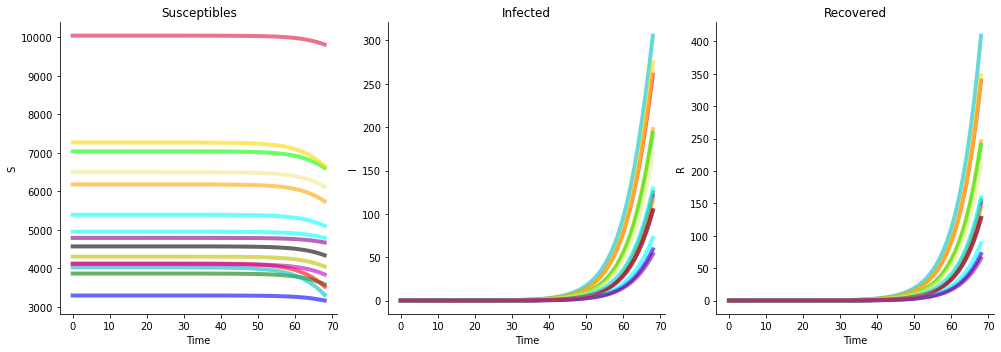

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=3, facecolor='w', figsize=(14,5))

# Susceptibles trend

ax = axs[0]
ax.set_title('Susceptibles')
colors = ['b', 'g', 'r', 'c','m','y','k','w','orange','lime','gold','khaki','aqua','cyan','darkmagenta','crimson']
for i in range(len(S)):
    ax.plot(t, S[i], colors[i], alpha=0.6, lw=4)
ax.set_xlabel('Time')
ax.set_ylabel('S')

# Infected trend

ax = axs[1]
ax.set_title('Infected')
for i in range(len(I)):
    ax.plot(t, I[i], colors[i], alpha=0.6, lw=4)
ax.set_xlabel('Time')
ax.set_ylabel('I')

# Recovered trend

ax = axs[2]
ax.set_title('Recovered')
for i in range(len(R)):
    ax.plot(t, R[i], colors[i], alpha=0.6, lw=4)
ax.set_xlabel('Time')
ax.set_ylabel('R')
               
fig.tight_layout()
               
for aa in range(3):
    ax = axs[aa]
    for spine in ('top', 'right'): 
        ax.spines[spine].set_visible(False)

fig.savefig(f"Como44.png")

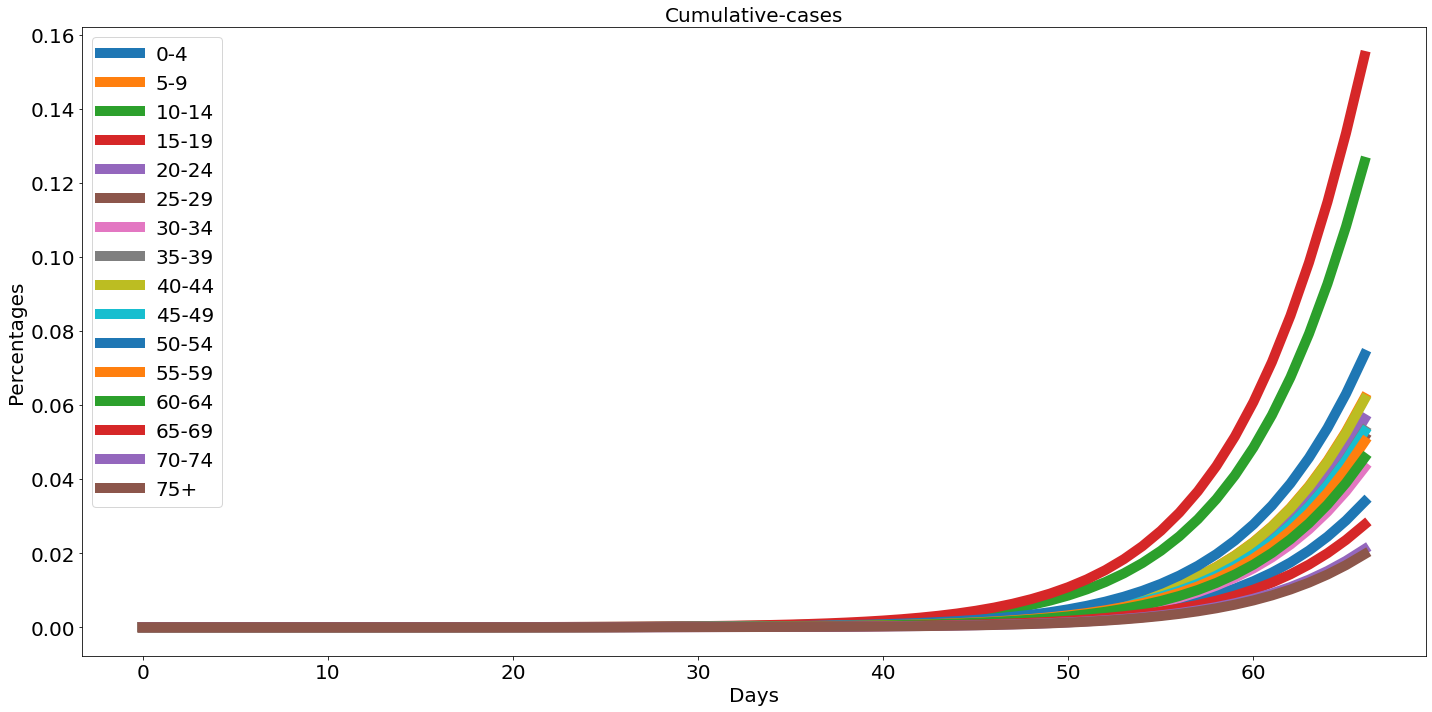

In [22]:
# Most infected, computed as the growing percentage with respect to the starting value of S for each group

I_hats = []

for i in range(len(I)):
    I_daily = (I[i][1:] + R[i][1:]) - (I[i][:-1] + R[i][:-1])
    I_hats.append(I_daily)

percentages = [np.cumsum(I_hats[i])/S0[i] for i in range(len(I))]

plt.figure(figsize=(20,10))

for i in range(len(percentages)):
    plt.plot(percentages[i][:67], label = list(como_pop['Age-range'].values)[i],lw=10)
    
plt.title('Cumulative-cases', fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlabel('Days', fontsize=20)
plt.ylabel('Percentages', fontsize=20)
plt.legend(loc="upper left", prop={'size': 20})
plt.tight_layout()
plt.savefig(f"Comomost.png")

# Exercise 3: Improve the model

First approach : DETERMINISTIC

BEST MODEL Best: RO: 1.88, MSE:1.15, q:0.017975901953801582


<ipython-input-15-5b95a1b4b23a>:59: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
<ipython-input-15-5b95a1b4b23a>:60: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(f"Como22.png")
C:\Users\alber\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


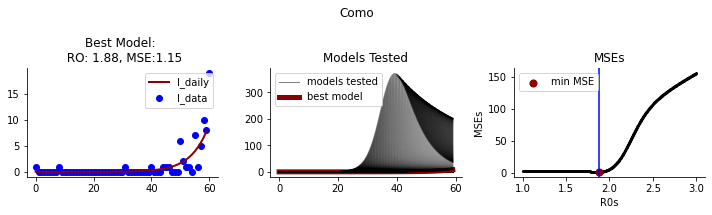

In [23]:
proporzione = np.array([i/597642 for i in como_pop['Population']])

S0 = (85543) * proporzione
COMO = [i for i in S0]
S0[-1] = S0[-1] - 1
I0 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]) * proporzione
R0 = np.array([0]*16) 

INPUT =np.hstack((S0,I0,R0))

T = 60 # Using a different timeframe, since we want to calibrate just the first 60 days
steps_per_t = 1
t = np.arange(0, T+1, 1/steps_per_t)  

R0_trials1(INPUT, t, matrix, COMO)

In [24]:
q =  0.017975901953801582  # Best q computed over the first 60 days
valore_matrice = q * matrix.values
d = 5
gamma = 1/d

RES = odeint(SIR_eq, INPUT ,t, args=(valore_matrice, gamma,COMO))

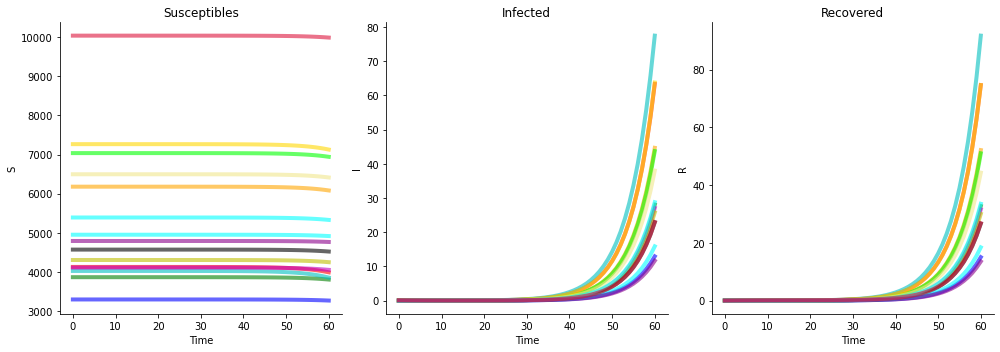

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=3, facecolor='w', figsize=(14,5))

# Susceptibles

ax = axs[0]
ax.set_title('Susceptibles')
colors = ['b', 'g', 'r', 'c','m','y','k','w','orange','lime','gold','khaki','aqua','cyan','darkmagenta','crimson']
for i in range(len(RES.T[:16])):
    ax.plot(RES.T[:16][i], colors[i], alpha=0.6, lw=4)
ax.set_xlabel('Time')
ax.set_ylabel('S')

# Infected

ax = axs[1]
ax.set_title('Infected')
for i in range(len(RES.T[16:32])):
    ax.plot(RES.T[16:32][i], colors[i], alpha=0.6, lw=4)
ax.set_xlabel('Time')
ax.set_ylabel('I')

# Recovered

ax = axs[2]
ax.set_title('Recovered')
for i in range(len(RES.T[32:])):
    ax.plot(RES.T[32:][i], colors[i], alpha=0.6, lw=4)
ax.set_xlabel('Time')
ax.set_ylabel('R')
               
fig.tight_layout()
               
for aa in range(3):
    ax = axs[aa]
    for spine in ('top', 'right'): 
        ax.spines[spine].set_visible(False)

In [26]:
# At time 60, we introduce closing schools. This action is affecting just age ranges from 0 to 25, and is acting just 
# on themselves. The value of Cij for i = 10-15 and j = 60-65 stays the same. We act on the BOX

# We take as starting input the LAST value computed for step 1

SS = [i[60] for i in RES.T[:16]]
II = [i[60] for i in RES.T[16:32]]
RR = [i[60] for i in RES.T[32:]]

In [27]:
def R0_trials2(INPUT, time, matrix, listone, x, y):
    MSEs = []  
    I_hats = []
    lista_eigen = []  # empty list where to store the values that we try for the BOX
    d = 5 
    gamma= 1/d
    q = 0.017975901953801582
    eigen = np.arange(0.001, 2, 0.001)
    for eig in eigen:
        d = np.ones((16,16))
        d[:5,:5] = eig   # Box
        valore_matrice = d * (q * matrix.values)
        RES = odeint(SIR_eq, INPUT ,time, args=(valore_matrice, gamma, listone))
        S, I, R = RES.T[:16], RES.T[16:32], RES.T[32:]
        for i in range(len(I)):
            I_daily = (I[i][1:] + R[i][1:]) - (I[i][:-1] + R[i][:-1])
        I_hats.append(I_daily)
        lista_eigen.append(eigen)
        true_data = file['Como'][x:y]
        MSE = np.sqrt(sum((I_daily-true_data)**2)/len(true_data))
        MSEs.append(MSE)
    cal = pd.DataFrame({'MSE': MSEs, 'I_hat': I_hats, 'eigen': eigen})
    best_model = cal.loc[cal['MSE'].idxmin()]
    print('BEST MODEL {}: MSE:{}, eigen:{}'.format('Best', round(best_model['MSE'],2), best_model['eigen']))

In [28]:
INPUT2 =np.hstack((SS,II,RR))

TT = 10
steps_per_tt = 1
tt = np.arange(0, TT+1, 1/steps_per_tt)  

R0_trials2(INPUT2, tt, matrix, SS, 60,70)

BEST MODEL Best: MSE:7.01, eigen:1.224


In [29]:
q = 0.017975901953801582
d = np.ones((16,16))
d[:5,:5] = 1.224  # Best value for the box to resemble the pattern between day 60 and day 69

valore_matrice1 = d * q * matrix.values

RESS = odeint(SIR_eq, INPUT2 ,tt, args=(valore_matrice1, gamma,SS))

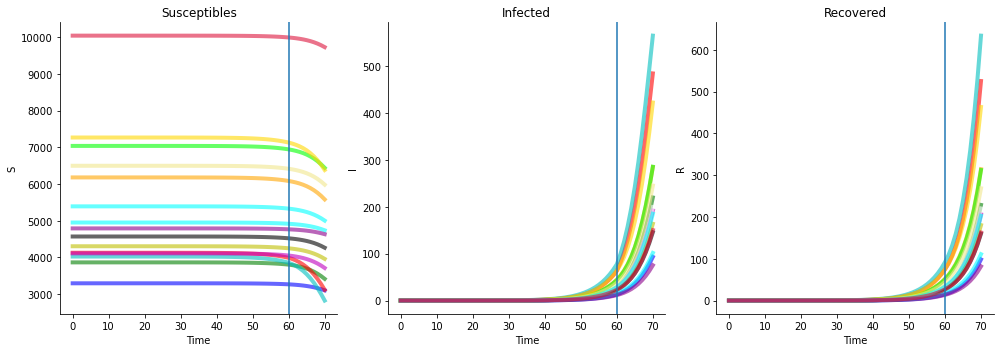

In [30]:
# Concatenation between values from the first step and the second step

toto1 = [np.concatenate([RES.T[:16][i],RESS.T[:16][i][1:]]) for i in range(len(RES.T[:16]))]
    
toto2 = [np.concatenate([RES.T[16:32][i],RESS.T[16:32][i][1:]]) for i in range(len(RES.T[16:32]))]
    
toto3 = [np.concatenate([RES.T[32:][i],RESS.T[32:][i][1:]]) for i in range(len(RES.T[32:]))]

# Plots

fig, axs = plt.subplots(nrows=1, ncols=3, facecolor='w', figsize=(14,5))

# Susceptibles

ax = axs[0]
ax.set_title('Susceptibles')
colors = ['b', 'g', 'r', 'c','m','y','k','w','orange','lime','gold','khaki','aqua','cyan','darkmagenta','crimson']
for i in range(len(toto1)):
    ax.plot(toto1[i], colors[i], alpha=0.6, lw=4)
ax.set_xlabel('Time')
ax.set_ylabel('S')
ax.axvline(x=60)

# Infected

ax = axs[1]
ax.set_title('Infected')
for i in range(len(toto2)):
    ax.plot(toto2[i], colors[i], alpha=0.6, lw=4)
ax.set_xlabel('Time')
ax.set_ylabel('I')
ax.axvline(x=60)

# Recovered

ax = axs[2]
ax.set_title('Recovered')
for i in range(len(toto3)):
    ax.plot(toto3[i], colors[i], alpha=0.6, lw=4)
ax.set_xlabel('Time')
ax.set_ylabel('R')
ax.axvline(x=60)
               
fig.tight_layout()
               
for aa in range(3):
    ax = axs[aa]
    for spine in ('top', 'right'): 
        ax.spines[spine].set_visible(False)
        
fig.savefig(f"det1.png")

In [31]:
#At time 70, we introduce quarantine, and we act on the whole of the population

# We take as starting input the LAST value computed for step 2

SS1 = [i[10] for i in RESS.T[:16]]
II1 = [i[10] for i in RESS.T[16:32]]
RR1 = [i[10] for i in RESS.T[32:]]

In [32]:
def R0_trials3(INPUT, time, matrix, listone, x, y):
    MSEs = []  
    I_hats = []
    lista_eigen2 = [] # empty list where to store all the values that we test for the quarantine
    d = 5 
    gamma= 1/d
    q = 0.017975901953801582
    eigen2 = np.arange(0.001, 3, 0.001)
    for eig in eigen2:
        d = np.ones((16,16))
        d[:5,:5] = 1.224
        valore_matrice = eig * (d * (q * matrix.values)) # computing the matrix
        res = odeint(SIR_eq, INPUT ,time, args=(valore_matrice, gamma, listone))
        S, I, R = res.T[:16], res.T[16:32], res.T[32:]
        for i in range(len(I)):
            I_daily = (I[i][1:] + R[i][1:]) - (I[i][:-1] + R[i][:-1])
        I_hats.append(I_daily)
        lista_eigen2.append(eigen2)
        true_data = file['Como'][x:y]
        MSE = np.sqrt(sum((I_daily-true_data)**2)/len(true_data))
        MSEs.append(MSE)
    cal = pd.DataFrame({'MSE': MSEs, 'I_hat': I_hats, 'eigen2': eigen2})
    best_model = cal.loc[cal['MSE'].idxmin()]
    print('BEST MODEL {}: MSE:{}, eigen2:{}'.format('Best', round(best_model['MSE'],2), best_model['eigen2']))

In [33]:
INPUT3 =np.hstack((SS1,II1,RR1))

TTT = 10
steps_per_ttt = 1
ttt = np.arange(0, TTT+1, 1/steps_per_ttt)  

R0_trials3(INPUT3, ttt, matrix, SS1, 70,80)

BEST MODEL Best: MSE:10.53, eigen2:0.609


In [34]:
q = 0.017975901953801582
d = np.ones((16,16))
d[:5,:5] = 1.224 
quar = 0.609 # optimal value to resemble timeframe from 70 to 79

valore_matrice2 = quar * (d * (q * matrix.values))

RESSS = odeint(SIR_eq, INPUT3 ,ttt, args=(valore_matrice2, gamma, SS1))

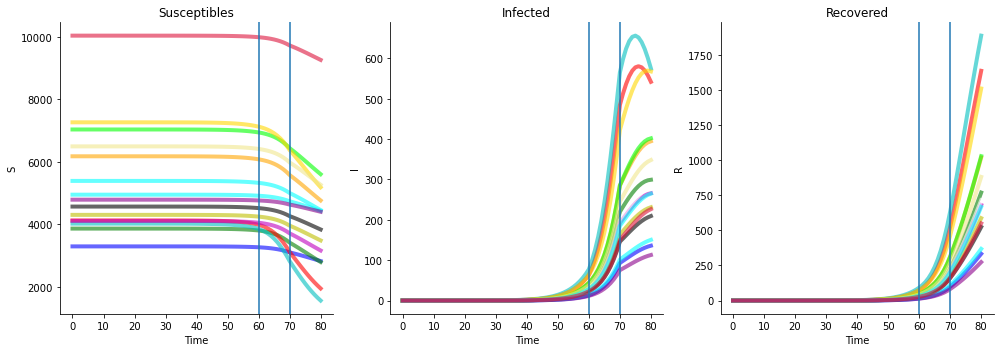

In [35]:
# concatenating steps 1, 2 and 3

toto4 = [np.concatenate([RES.T[:16][i],RESS.T[:16][i][1:],RESSS.T[:16][i][1:]]) for i in range(len(RES.T[:16]))]
    
toto5 = [np.concatenate([RES.T[16:32][i],RESS.T[16:32][i][1:], RESSS.T[16:32][i][1:]]) for i in range(len(RES.T[16:32]))]
    
toto6 = [np.concatenate([RES.T[32:][i],RESS.T[32:][i][1:],RESSS.T[32:][i][1:]]) for i in range(len(RES.T[32:]))]

# Plots

fig, axs = plt.subplots(nrows=1, ncols=3, facecolor='w', figsize=(14,5))

# Susceptibles

ax = axs[0]
ax.set_title('Susceptibles')
colors = ['b', 'g', 'r', 'c','m','y','k','w','orange','lime','gold','khaki','aqua','cyan','darkmagenta','crimson']
for i in range(len(toto4)):
    ax.plot(toto4[i], colors[i], alpha=0.6, lw=4)
ax.set_xlabel('Time')
ax.set_ylabel('S')
ax.axvline(x=70)
ax.axvline(x=60)

# Infected

ax = axs[1]
ax.set_title('Infected')
for i in range(len(toto5)):
    ax.plot(toto5[i], colors[i], alpha=0.6, lw=4)
ax.set_xlabel('Time')
ax.set_ylabel('I')
ax.axvline(x=70)
ax.axvline(x=60)

# Recovered

ax = axs[2]
ax.set_title('Recovered')
for i in range(len(toto6)):
    ax.plot(toto6[i], colors[i], alpha=0.6, lw=4)
ax.set_xlabel('Time')
ax.set_ylabel('R')
ax.axvline(x=70)
ax.axvline(x=60)
               
fig.tight_layout()
               
for aa in range(3):
    ax = axs[aa]
    for spine in ('top', 'right'): 
        ax.spines[spine].set_visible(False)

fig.savefig(f"det2.png")

In [36]:
#At time 80, we introduce masks, that reduce even more the spread of virus

# We take as starting input the LAST value computed for step 3

SS2 = [i[10] for i in RESSS.T[:16]]
II2 = [i[10] for i in RESSS.T[16:32]]
RR2 = [i[10] for i in RESSS.T[32:]]

In [37]:
def R0_trials4(INPUT, time, matrix, listone, x, y):
    MSEs = []  
    I_hats = []
    lista_eigen3 = [] # list where to store the values tested to resemble the pattern from time 80 until the end
    d = 5 
    gamma= 1/d
    q = 0.017975901953801582
    eigen2 = 0.609
    eigen3 = np.arange(0.001, 3, 0.001)
    for eig in eigen3:
        d = np.ones((16,16))
        d[:5,:5] = 1.224
        valore_matrice = eig * (eigen2 * (d * (q * matrix.values))) # computing the matrix
        res = odeint(SIR_eq, INPUT ,time, args=(valore_matrice, gamma, listone))
        S, I, R = res.T[:16], res.T[16:32], res.T[32:]
        for i in range(len(I)):
            I_daily = (I[i][1:] + R[i][1:]) - (I[i][:-1] + R[i][:-1])
        I_hats.append(I_daily)
        lista_eigen3.append(eigen3)
        true_data = file['Como'][x:y]
        MSE = np.sqrt(sum((I_daily-true_data)**2)/len(true_data))
        MSEs.append(MSE)
    cal = pd.DataFrame({'MSE': MSEs, 'I_hat': I_hats, 'eigen3': eigen3})
    best_model = cal.loc[cal['MSE'].idxmin()]
    print('BEST MODEL {}: MSE:{}, eigen3:{}'.format('Best', round(best_model['MSE'],2), best_model['eigen3']))

In [38]:
INPUT4 =np.hstack((SS2,II2,RR2))

TTTT = 12
steps_per_tttt = 1
tttt = np.arange(0, TTTT+1, 1/steps_per_tttt)  

R0_trials4(INPUT4, tttt, matrix, SS2, 80,92)

BEST MODEL Best: MSE:8.0, eigen3:0.42


In [39]:
q = 0.017975901953801582
d = np.ones((16,16))
d[:5,:5] = 1.224
quar = 0.609
mask = 0.42 # optimal value to resemble timeframe from 80 until the end

valore_matrice3 = mask * (quar * (d * (q * matrix.values)))

RESSSS = odeint(SIR_eq, INPUT4 ,tttt, args=(valore_matrice3, gamma, SS2))

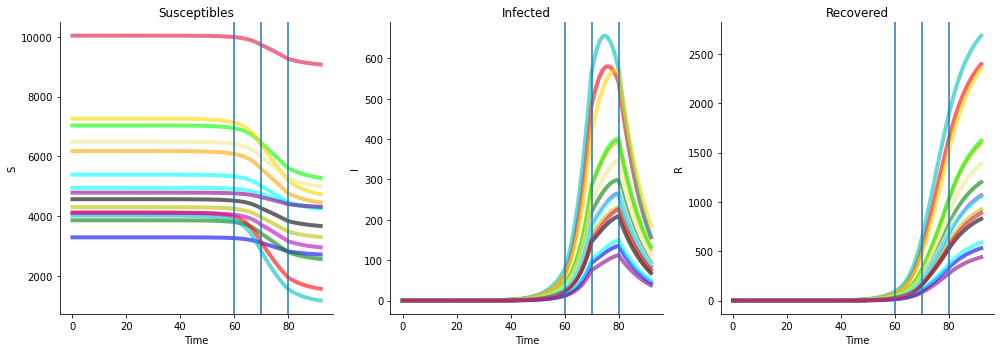

In [40]:
# concatenating steps 1, 2, 3 and 4

toto7 = [np.concatenate([RES.T[:16][i],RESS.T[:16][i][1:],RESSS.T[:16][i][1:],RESSSS.T[:16][i][1:]]) for i in range(len(RES.T[:16]))]
    
toto8 = [np.concatenate([RES.T[16:32][i],RESS.T[16:32][i][1:], RESSS.T[16:32][i][1:],RESSSS.T[16:32][i][1:]]) for i in range(len(RES.T[16:32]))]
    
toto9 = [np.concatenate([RES.T[32:][i],RESS.T[32:][i][1:],RESSS.T[32:][i][1:],RESSSS.T[32:][i][1:]]) for i in range(len(RES.T[32:]))]

# Plots

fig, axs = plt.subplots(nrows=1, ncols=3, facecolor='w', figsize=(14,5))

# Susceptibles

ax = axs[0]
ax.set_title('Susceptibles')
colors = ['b', 'g', 'r', 'c','m','y','k','w','orange','lime','gold','khaki','aqua','cyan','darkmagenta','crimson']
for i in range(len(toto7)):
    ax.plot(toto7[i], colors[i], alpha=0.6, lw=4)
ax.set_xlabel('Time')
ax.set_ylabel('S')
ax.axvline(x=60)
ax.axvline(x=70)
ax.axvline(x=80)

# Infected

ax = axs[1]
ax.set_title('Infected')
for i in range(len(toto8)):
    ax.plot(toto8[i], colors[i], alpha=0.6, lw=4)
ax.set_xlabel('Time')
ax.set_ylabel('I')
ax.axvline(x=60)
ax.axvline(x=70)
ax.axvline(x=80)

# Recovered

ax = axs[2]
ax.set_title('Recovered')
for i in range(len(toto9)):
    ax.plot(toto9[i], colors[i], alpha=0.6, lw=4)
ax.set_xlabel('Time')
ax.set_ylabel('R')
ax.axvline(x=60)
ax.axvline(x=70)
ax.axvline(x=80)
               
fig.tight_layout()
               
for aa in range(3):
    ax = axs[aa]
    for spine in ('top', 'right'): 
        ax.spines[spine].set_visible(False)
        
fig.savefig(f"det3.png")

In [41]:
#FINAL MSE FOR THE CURVE PREDICTED BY BLOCKS

# Computing every I_daily on the final concatenation

I_hats = []

for i in range(len(toto8)):
    I_daily = (toto8[i][1:] + toto9[i][1:]) - (toto8[i][:-1] + toto9[i][:-1])

I_hats.append(I_daily)

true_data = file['Como']

# Computing the MSE between REAL DATA and the concatenation of each of the four STEPS

MSE = np.sqrt(sum((I_daily-true_data)**2)/len(true_data))

print(MSE)

5.156224666739412


Second approach: STOCHASTIC

In [42]:
# returns number of individuals changing status within a timestep
# this is the function to insert stochasticity in the model, since the S and the I are automatically changing over time

def computeTransitions(popoulation_at_risk, event_rate, time_step):
    p = event_rate
    n_of_events = np.random.binomial(popoulation_at_risk, p, 1)
    return(n_of_events)

In [43]:
def SIR(INPUT, ndays, matrix, coeff_quar, coeff_school):
    SS, II, RR = INPUT[:16].reshape((1,16)), INPUT[16:32].reshape((1,16)), INPUT[32:].reshape((1,16)) 
    lista_v = []
    time_step = 1 
    t = np.arange(0, ndays)
    q = 0.018157766776550364 # Optimal q from the 2nd exercise
    beta = q * matrix.values
    d = np.ones((16,16))
    d[:5,:5] = coeff_school
    beta2 = d * (q * matrix.values)
    
    for i in t:
        
        S_temp = []
        I_temp = []
        R_temp = []
        
        for j in range(16):
            
            if i <= 50:
                lambda_ = np.dot(beta[j], II[-1]/(N*proporzione))
            elif (i > 50 and i<= 68):
                lambda_ = np.dot(beta2[j], II[-1]/(N*proporzione))
            elif i > 68:
                lambda_ = coeff_quar * (np.dot(beta2[j], II[-1]/(N*proporzione)))
                
                # new infections are possible only if S>0 and lamba>0  
            if (lambda_ > 0) & (SS[-1][j]>0):
                new_infections = computeTransitions(SS[-1][j],lambda_,time_step)[0] 
                #print(S[-1][j])
                #print(lambda_)
            elif (lambda_<=0) | (SS[-1][j]<=0):
                new_infections=0
                
            # new recoveries are possible only if I>0
            if(II[-1][j]>0):
                new_recoveries = computeTransitions(II[-1][j],gamma,time_step)[0]
            else:
                new_recoveries=0
            
        # control that new infections do not exceed available susceptibles
            if(new_infections > SS[-1][j]):
                new_infections = SS[-1][j]
    
            # control that new recoveries do not exceed available infected individuals
            if(new_recoveries>II[-1][j]):
                new_recoveries = II[-1][j]
    
            S_temp.append(new_infections)
            I_temp.append(new_infections - new_recoveries)
            R_temp.append(new_recoveries)
 
        new_arr_S = SS[-1] - np.array(S_temp)
        SS = np.concatenate((SS, new_arr_S.reshape((1,16))),axis=0)
        
        new_arr_I = II[-1] + np.array(I_temp)
        II = np.concatenate((II, new_arr_I.reshape((1,16))),axis=0)
        
        new_arr_R = RR[-1] + np.array(R_temp)
        RR = np.concatenate((RR, new_arr_R.reshape((1,16))),axis=0)

    return SS , II , RR

In [44]:
# let's re-build our INPUT for the function we defined above

proporzione = np.array([i/597642 for i in como_pop['Population']])
N = 85543
sS = (85543) * proporzione
listone = [i for i in sS]
sS[3] = sS[3] - 1
iI = np.array([0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0])
rR = np.array([0]*16) 
INPUT =np.hstack((sS,iI,rR))

gamma = 1/5

In [45]:
import sys 

# Let's run 100 simulation, in order to have realiable results

nsim=100
Ss = []
Is= []
Rs = []
for isim in range(1,nsim+1):
    sys.stdout.write('\rSimulation n°: {}'.format(isim))
    sss,iii,rrr = SIR(INPUT, 92, matrix, 0.2, 0.1)
    Ss.append(sss)
    Is.append(iii)
    Rs.append(rrr)
print('\nDone!')   

Simulation n°: 100
Done!


In [46]:
# Since we have tensors, we need to have two dimensions, and no more three. Let's make the mean and the standard deviation
# for the simulations

meanS = np.mean(Ss, axis=0)[:-1]
meanI = np.mean(Is, axis=0)[:-1]
meanR = np.mean(Rs, axis=0)[:-1]

sdS = np.std(Ss, axis=0, dtype=np.float64)[:-1]
sdI = np.std(Is, axis=0, dtype=np.float64)[:-1]
sdR = np.std(Rs, axis=0, dtype=np.float64)[:-1]

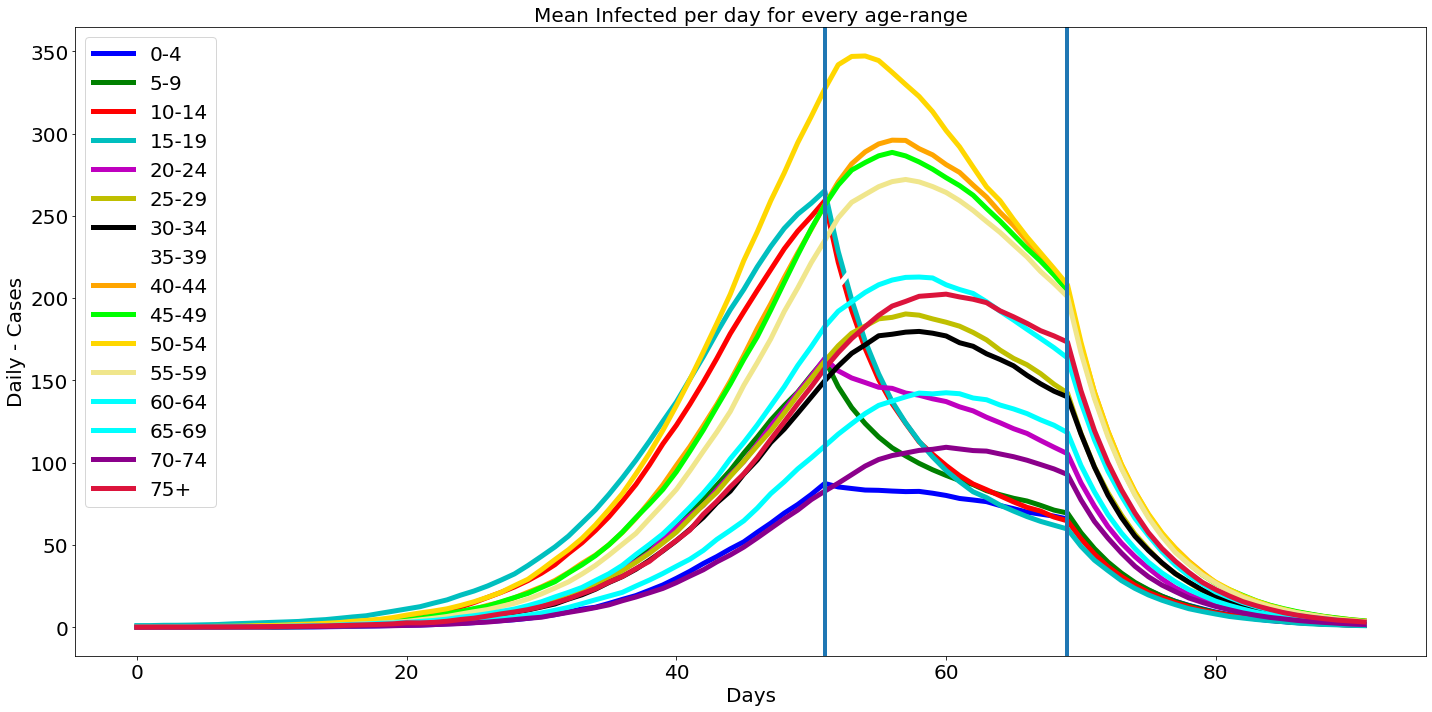

In [47]:
# Plots

# Plots for infected per age-range

plt.figure(figsize=(20,10))

colors = ['b', 'g', 'r', 'c','m','y','k','w','orange','lime','gold','khaki','aqua','cyan','darkmagenta','crimson']

for i in range(len(meanI.T)):
    plt.plot(meanI.T[i], label = list(como_pop['Age-range'])[i], c = colors[i], linewidth=5)

plt.axvline(x=51, lw = 4)
plt.axvline(x=69, lw = 4)
plt.title('Mean Infected per day for every age-range', fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlabel('Days', fontsize=20)
plt.ylabel('Daily - Cases', fontsize=20)
plt.legend(loc="upper left", prop={'size': 20})
plt.tight_layout()
plt.savefig("meaninf1.png")

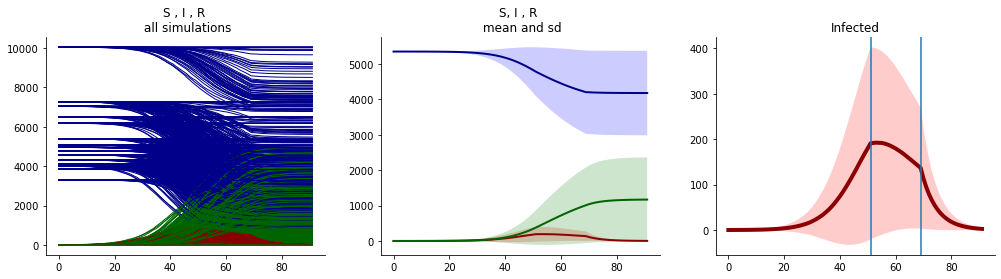

In [48]:
# Plots

t = np.arange(0, 92, 1/1)
fig, axs = plt.subplots(1,3, facecolor='w', figsize=(17,4))

# All simulations together

axs[0].set_title('S , I , R \n all simulations')
for  S,I,R in zip(Ss, Is, Rs):
    axs[0].plot(t, S[:-1], c = 'darkblue', lw=1)
    axs[0].plot(t, I[:-1], c = 'darkred', lw=1)
    axs[0].plot(t, R[:-1], c = 'darkgreen', lw=1)

# Mean of all age ranges, filled between mean of the standard deviations
    
axs[1].set_title('S, I , R \n mean and sd')
axs[1].plot(t, [(np.mean(i)) for i in meanS], c = 'darkblue', lw=2, label = 'mean S')
axs[1].fill_between(t, [[np.mean(i) for i in meanS][i] + [np.mean(i) for i in sdS][i] for i in range(len(meanS))]\
                    ,  [[np.mean(i) for i in meanS][i] - [np.mean(i) for i in sdS][i] for i in range(len(meanS))]\
                    , facecolor='blue', alpha=0.2)
axs[1].plot(t, [(np.mean(i)) for i in meanI], c = 'darkred', lw=2, label = 'mean I')
axs[1].fill_between(t, [[np.mean(i) for i in meanI][i] + [np.mean(i) for i in sdI][i] for i in range(len(meanI))]\
                    ,  [[np.mean(i) for i in meanI][i] - [np.mean(i) for i in sdI][i] for i in range(len(meanI))]\
                    , facecolor='red', alpha=0.2)
axs[1].plot(t, [(np.mean(i)) for i in meanR], c = 'darkgreen', lw=2, label = 'mean R')
axs[1].fill_between(t, [[np.mean(i) for i in meanR][i] + [np.mean(i) for i in sdR][i] for i in range(len(meanR))]\
                    ,  [[np.mean(i) for i in meanR][i] - [np.mean(i) for i in sdR][i] for i in range(len(meanR))]\
                    , facecolor='green', alpha=0.2)

# Focus of plot 2 on infected people

axs[2].set_title('Infected')
axs[2].plot(t, [(np.mean(i)) for i in meanI], c = 'darkred', lw=4, label = 'mean I')
axs[2].fill_between(t, [[np.mean(i) for i in meanI][i] + [np.mean(i) for i in sdI][i] for i in range(len(meanI))]\
                    ,  [[np.mean(i) for i in meanI][i] - [np.mean(i) for i in sdI][i] for i in range(len(meanI))]\
                    , facecolor='r', alpha=0.2)
axs[2].axvline(x=51)
axs[2].axvline(x=69)
    
for i in range(3):
    for spine in ('top', 'right'): 
        axs[i].spines[spine].set_visible(False)
        
fig.savefig("meanmeanmean.png")